In [29]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nodevectors
import umap.umap_ as umap

import sys
import os

In [30]:
# Add the root of the project to the Python path
base_dir = os.path.abspath('..')
sys.path.append(base_dir)

from graph_matching.data_loader.graph_loader import NetworkLoader

In [56]:
#atlas = 'Glasser'
atlas = 'Schaefer1000'
structure_type = 'ses-01'

loader = NetworkLoader(
    atlas=atlas,
   structure_type=structure_type,
   base_dir=base_dir+'/data_new_struct'
   )

In [57]:
(user_id, network) = next(loader)
print(network.shape)

(1000, 1000)


# Do the embedding using PronE and visualize using umap

In [58]:
# Use nodevectors to embed the network using ProNE
proNE = nodevectors.ProNE()
embeddings = proNE.fit_transform(nx.from_numpy_matrix(A=network))

/opt/anaconda3/envs/graph_matching/lib/python3.11/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


In [59]:
# Use UMAP to reduce the dimensionality of the embeddings
umap_model = umap.UMAP(n_components=2, random_state=1)
umap_embeddings = umap_model.fit_transform(embeddings)

/opt/anaconda3/envs/graph_matching/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


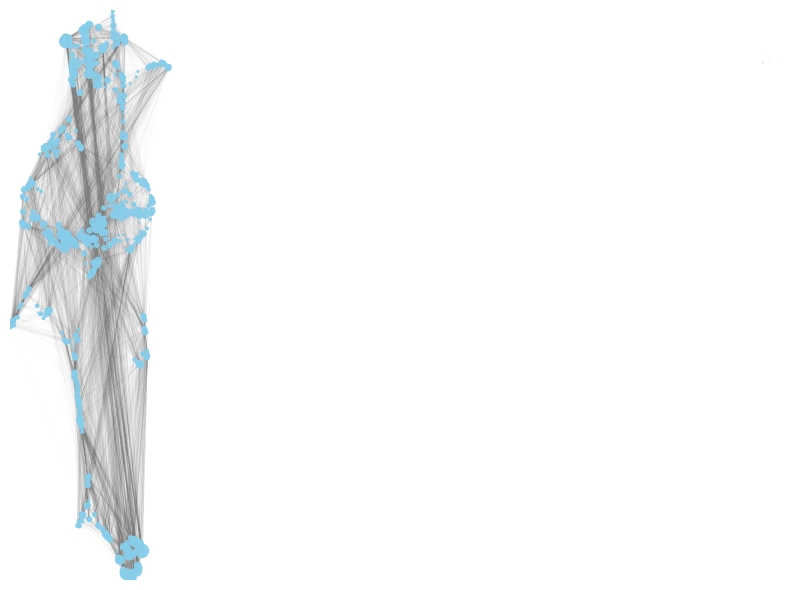

In [73]:
node_base_size = 0.01
edge_base_size = 0.01

# Create a new graph for visualization
H = nx.Graph()

# Add nodes and their embeddings to the new graph
for i, (x, y) in enumerate(umap_embeddings):
    H.add_node(i, pos=(x, y))

# Add edges to the new graph
for i in range(len(network)):
    for j in range(i+1, len(network)):
        if network[i, j] > 0:
            H.add_edge(i, j, weight=network[i, j])

# Get positions for the nodes in the new graph
pos = nx.get_node_attributes(H, 'pos')
# Calculate the weighted degree for each node
weighted_degrees = dict(H.degree(weight='weight'))
# Extract edge weights
edge_weights = [np.log10(H[u][v]['weight']) * edge_base_size for u, v in H.edges()]
node_sizes = [weighted_degrees[node] * node_base_size for node in H.nodes()]

xmin, xmax = np.min(umap_embeddings[:,0]), np.max(umap_embeddings[:,0])
ymin, ymax = np.min(umap_embeddings[:,1]), np.max(umap_embeddings[:,1])

## Plot the embedded network using networkx
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(
    H,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color='skyblue',
    edge_color='gray',
    width=edge_weights,
    alpha=0.9,
    ax=ax
    )
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.tight_layout()
plt.show()
plt.close()

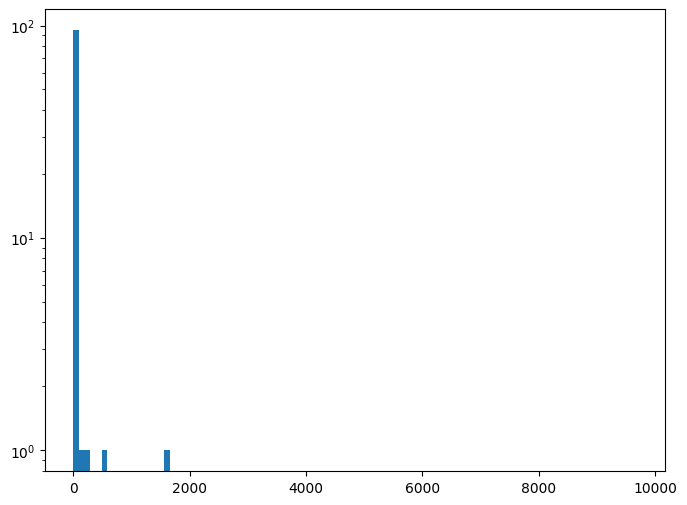

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
counts, bins = np.histogram(network.flatten(), bins=100)
ax.hist(counts, bins[:-1])
ax.set_yscale('log')
plt.show()